# Section 1 
Name: Michelle Fong  


## Question 1-I

Hard clustering classifies datapoints to only 1 cluster and the available classes are 0 or 1 only, kmean is an example of hard clustering. Assume there is a collection of documents $\{d_1, d_2, \dots, d_N\}$ to be clustered into K clusters. Each document contains some words and the all words from documents create a shared dictionary A.  

Assume the label of the data is unknown and so there is incomplete data.

We want to derive the likelihood of documents with hidden variable z_n representing the label, thus:
$$
p(d_1, d_2 , \dots, d_n) = \prod_{n= 1}^{N} p(d_i) = \prod_{n= 1}^{N} \sum_{k=1}^{K} p(d_n, z_n = k) = \prod_{n= 1}^{N} \sum_{k=1}^{K} (\varphi_{k} \prod_{w \in A}{\mu_{kw}^{c(w, d_n)}})
$$

Since summing product sum is difficult, EM optimization is used for the case of summing .  

<u>E-Step </u>: estimate the distribution of the hidden variable to find the tight lower bound Q  
Hard Clustering:  
$$
r(z_{nk}) = p(z_n = k | d_n, \theta_{old}) = argmax(p(z_{nk} = 1 | d_n, \theta_{old}))
$$

Soft Clustering:  
$$
r(z_{nk}) = p(z_n = k | d_n, \theta_{old}) = p(z_{nk} = 1 | d_n, \theta_{old})
$$

This is the probability that the word is within the cluster k

<u>M-Step </u>: maximise the expected complete data log likelihood
$$\begin{aligned}
Q(\theta, \theta^{old}) 
&= \sum_{n=1}^{N} \sum_{k=1}^{K} p(z_{nk}=1 | d_n, \theta^{old})\log p(z_{nk}=1, d_n |\theta)\\
&= \sum_{n=1}^{N} \sum_{k=1}^{K} r{z_{nk}}\log (\varphi_{k} \prod_{w \in A}{\mu_{kw}^{c(w, d_n)}})\\
&= \sum_{n=1}^{N} \sum_{k=1}^{K} r{z_{nk}} (\log (\varphi_{k} + \sum_{w\in A} {c(w, d_n) \log \mu_{kw}})\\
\end{aligned}
$$

$$
\begin{equation}
\varphi_{k} = \frac{N_k}{N},
\quad N_k = \sum_{n=1}^{N}r({z_{nk})},
\quad \mu_{kw} = \frac{\sum_{n=1}^{N}{r(z_{nk})c(w,d_n)}}{\sum_{w' \in A}{\sum_{n=1}^{N}r({z_{nk})c(w',d_n)}}}
\end{equation}
$$
where 
- $\varphi_{k}$ is the prior proportion of the documents clustered to k
- $N_k$ is the total document cluster to cluster k
- $\mu_{kw}$ is the word proportion
- $c(w_d, d_n)$ is the total occurance of w_d in the d_n


Parameters: $\theta^{0} = (\varphi^0, \mu_1^0, \dots, \mu_K^0)$ is the initial guess  of the parameters  
In each step of EM optimization, follow to above derivation:
- E-step: update $r(z_{nk})$ fixing $\theta^t$
- M-step: update $\theta^{t+1}$ fixing $r(z_{nk})$ by solving MLE for the expected completed data log likelihood

## Q1 - II

In [1]:
import pandas as pd 
import numpy as np

with open('Task2A.txt', 'r') as file:
    # read all lines as a list
    text = file.readlines()

# split by tab & check if len = 2
all([length == 2 for length in [len(line.split('\t')) for line in text]])

# extract labels and article after splitting
labels, articles = [line.split('\t')[0].strip() for line in text], [line.split('\t')[1].strip() for line in text]

# to df
docs = pd.DataFrame(data = zip(labels,articles), columns=['label', 'article'])
docs.label = docs.label.astype('category')
docs.head()

,label,article
0,sci.crypt,ripem frequently asked questions archive name ...
1,sci.crypt,ripem frequently asked questions archive name ...
2,sci.crypt,ripem frequently noted vulnerabilities archive...
3,sci.crypt,certifying authority question answered if you ...
4,sci.crypt,rubber hose cryptanalysis some sick part of me...


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(lowercase=True,
                     stop_words='english',
                     min_df=5,
                    norm='l2')  # note that specifying the norm will normalise the data for us



features = tfidf.fit_transform(raw_documents=docs.article.values)
features.shape

(2373, 8094)

In [3]:
print(features.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [4]:
features.toarray().shape
# (num of docu, num of words)

(2373, 8094)

In [5]:
non_zero_indices = features.nonzero()
# document indices
row_indices = non_zero_indices[0]
row_indices

# feature or word indices
column_indices = non_zero_indices[1]
# row_indices
column_indices

array([ 413, 4335, 6214, ..., 7895, 4139, 8013], dtype=int32)

## Q1 - III

In [6]:
# hard clustering
class HardEM:
    def __init__(self, K, tau_max=200, epsilon=0.01, random_state=None):
        self.K = K               # number of GMM clusters
        self.tau_max = tau_max   # max number of iterations
        self.epsilon = epsilon  # minimum acceptable error rate
        self.random_state = random_state
        np.random.seed(self.random_state)

    def get_params(self, deep=False):
        return {'K': self.K,
         'tau_max': self.tau_max,
         'epsilon': self.epsilon,
         'random_state': self.random_state}
    
    def __str__(self):
        params = self.get_params()
        return 'HardGMM({0})'.format(','.join(['='.join([key, str(params[key])]) for key in params.keys()]))

    def __repr__(self):
        return self.__str__()
                 
    def fit(self, X, verbose=False):
        # number of docu
        N = X.shape[0]
        # number of word
        D = X.shape[1]
        
        # Initialize model parameters
        # prior probabilities for clusters - assumed to be equal
        self.Psi_hat_ = np.array([1/self.K] * self.K)                         
        self.Nk_hat_ = self.Psi_hat_ * N          
        
        # random cluster means
        self.Mu_hat_ = np.random.rand(self.K, D)

        # hard clustering - binary 0/1 indicator of grouping
        r = np.zeros((N,self.K))                                     

        # Storing historic mean of cluster & dist
        self.Mu_hat_historic_ = np.zeros((self.K, D, self.tau_max))
        self.r_historic_ = np.zeros(shape=(N, self.K, self.tau_max))

        terminate= False
        tau = 0
        # fitting loop - we iteratively take E and M steps until the termination criterion is met.
        Mu_hat_old = self.Mu_hat_ # Mu_hat_old is used to store the last iteration value for mu_hat
        while (not terminate):
            if verbose: 
                print('iteration {0}'.format(tau))
                # Print Mu_hat for this iteration
            print('Mu_hat for iteration {0}:'.format(tau))
            print(self.Mu_hat_)

            

          # E-step: update r(z_nk) 
            # in each document
            for n in range(N):
                for k in range(self.K):
                    # Calculate the likelihood of document n under cluster k
                    likelihood = np.prod(self.Mu_hat_[k] ** X[n])

                    # post dist = prior * likelihood of complete data
                    # joint dist of each docu n cluster to k
                    # np.prod(mu[k] ** X[n]): from expected completet likelihood
                    r[n, k] = self.Psi_hat_[k] * likelihood

            max_clip_function = lambda x:  np.array([1 if i== x.argmax() else 0 for i in range(len(x))])
            z_n_hat = np.array(list(map(max_clip_function, r)), dtype='float32')
            r = z_n_hat

            self.r_historic_[:, :, tau] = z_n_hat



            # M-step: update theta fixing r(z_nk))
            self.Nk_hat_ = r.sum(axis=0)
            self.Psi_hat_ = self.Nk_hat_/N

            Mu_hat_new = np.zeros((self.K, D))


            for k in range(self.K): # each cluster
                # num  = (np.sum(r.T @ X)[k])
                num = r.T @ X
                deno = np.sum(num[k])
                Mu_hat_new[k,:]= num[k]/deno
            self.Mu_hat_ = Mu_hat_new
            self.Mu_hat_historic_[:, :, tau] = self.Mu_hat_

            # increase iteration counter
            tau +=1

            # check termination condition
            terminate = ((tau == self.tau_max) or np.allclose(self.Mu_hat_, Mu_hat_old, rtol= self.epsilon))
            # record the means (neccessary for checking the termination criteria)
            Mu_hat_old = self.Mu_hat_

        self.Mu_hat_historic_ = self.Mu_hat_historic_[:, :, :tau]
        self.r_historic_ = self.r_historic_[:, :, :tau]

        if verbose: 
            print(f'Converged in {tau} iterations')
        return self
        
        
    # In a clustering-context, `predict` is equivalent to obtaining cluster assignments for new data
    def predict_proba(self, X):
        N = X.shape[0]
        r = np.zeros((N,self.K))

        for n in range(N):
            for k in range(self.K):
                # Calculate the likelihood of document n under cluster k
                likelihood = np.prod(self.Mu_hat_[k] ** X[n])
                # Calculate the posterior probability that document n belongs to cluster k
                r[n, k] = self.Psi_hat_[k] * likelihood
        max_clip_function = lambda x:  np.array([1 if i== x.argmax() else 0 for i in range(len(x))])
        z_n_hat = np.array(list(map(max_clip_function, r)), dtype='float32')
        r = z_n_hat
        return r

    def predict(self, X):
        probs = self.predict_proba(X)
        preds = np.argmax(probs, axis=1)
        return preds


In [8]:
# soft clustering
class SoftEM:
    def __init__(self, K, tau_max=200, epsilon=0.01, random_state=None):
        self.K = K               # number of GMM clusters
        self.tau_max = tau_max   # max number of iterations
        self.epsilon = epsilon  # minimum acceptable error rate
        self.random_state = random_state
        np.random.seed(self.random_state)

    def get_params(self, deep=False):
        return {'K': self.K,
         'tau_max': self.tau_max,
         'epsilon': self.epsilon,
         'random_state': self.random_state}
    
    def __str__(self):
        params = self.get_params()
        return 'HardGMM({0})'.format(','.join(['='.join([key, str(params[key])]) for key in params.keys()]))

    def __repr__(self):
        return self.__str__()
                 
    def fit(self, X, verbose=False):
        # number of docu
        N = X.shape[0]
        # number of word
        D = X.shape[1]
        
        # Initialize model parameters
        # prior probabilities for clusters - assumed to be equal
        self.Psi_hat_ = np.array([1/self.K] * self.K)                         
        self.Nk_hat_ = self.Psi_hat_ * N          
        
        # random cluster means
        self.Mu_hat_ = np.random.rand(self.K, D)

        # hard clustering - binary 0/1 indicator of grouping
        r = np.zeros((N,self.K))                                     

        # Storing historic mean of cluster & dist
        self.Mu_hat_historic_ = np.zeros((self.K, D, self.tau_max))
        self.r_historic_ = np.zeros(shape=(N, self.K, self.tau_max))

        terminate= False
        tau = 0
        # fitting loop - we iteratively take E and M steps until the termination criterion is met.
        Mu_hat_old = self.Mu_hat_ # Mu_hat_old is used to store the last iteration value for mu_hat
        while (not terminate):
            if verbose: 
                print('iteration {0}'.format(tau))
                # Print Mu_hat for this iteration
            print('Mu_hat for iteration {0}:'.format(tau))
            print(self.Mu_hat_)

            

          # E-step: update r(z_nk) 
            # in each document
            for n in range(N):
                for k in range(self.K):
                    # Calculate the likelihood of document n under cluster k
                    likelihood = np.prod(self.Mu_hat_[k] ** X[n])

                    # post dist = prior * likelihood of complete data
                    # joint dist of each docu n cluster to k
                    # np.prod(mu[k] ** X[n]): from expected completet likelihood
                    r[n, k] = self.Psi_hat_[k] * likelihood
            r = (r == np.max(r, axis=1, keepdims=True)).astype(float)

            self.r_historic_[:, :, tau] = r

            
            # M-step: update theta fixing r(z_nk))
            self.Nk_hat_ = r.sum(axis=0)
            self.Psi_hat_ = self.Nk_hat_/N

            Mu_hat_new = np.zeros((self.K, D))

            for k in range(self.K): # each cluster
                # num  = (np.sum(r.T @ X)[k])
                num = r.T @ X
                deno = np.sum(num[k])
                Mu_hat_new[k,:]= num[k]/deno
            self.Mu_hat_ = Mu_hat_new
            self.Mu_hat_historic_[:, :, tau] = self.Mu_hat_


            # increase iteration counter
            tau +=1

            # check termination condition
            terminate = ((tau == self.tau_max) or np.allclose(self.Mu_hat_, Mu_hat_old, rtol= self.epsilon))
            # record the means (neccessary for checking the termination criteria)
            Mu_hat_old = self.Mu_hat_

        self.Mu_hat_historic_ = self.Mu_hat_historic_[:, :, :tau]
        self.r_historic_ = self.r_historic_[:, :, :tau]

        if verbose: 
            print(f'Converged in {tau} iterations')
        return self
        
        
    # In a clustering-context, `predict` is equivalent to obtaining cluster assignments for new data
    def predict_proba(self, X):
        N = X.shape[0]
        r = np.zeros((N,self.K))

        for n in range(N):
            for k in range(self.K):
                # Calculate the likelihood of document n under cluster k
                likelihood = np.prod(self.Mu_hat_[k] ** X[n])
                # Calculate the posterior probability that document n belongs to cluster k
                r[n, k] = self.Psi_hat_[k] * likelihood
        r = (r == np.max(r, axis=1, keepdims=True)).astype(float)

        return r

    def predict(self, X):
        probs = self.predict_proba(X)
        preds = np.argmax(probs, axis=1)
        return preds


## Q1 - IV

In [9]:
from sklearn.pipeline import make_pipeline

# Hard clustering
K = 4
X = features.toarray()
hard_em = HardEM(K=K, tau_max=100, epsilon=0.01, random_state=0)
hard_em.fit(X, verbose=True)
cluster_assignments = hard_em.predict(X)

print(cluster_assignments)


iteration 0
Mu_hat for iteration 0:
[[0.5488135  0.71518937 0.60276338 ... 0.34402606 0.26157885 0.39006907]
 [0.30089337 0.1597398  0.94173032 ... 0.74519745 0.19250094 0.35199941]
 [0.02130789 0.6214423  0.95035059 ... 0.01859348 0.95499249 0.70861025]
 [0.11836618 0.18068449 0.216401   ... 0.16759806 0.78601786 0.37977605]]
iteration 1
Mu_hat for iteration 1:
[[1.51707894e-04 5.60737626e-05 2.92281516e-04 ... 5.40316980e-04
  8.32734585e-05 1.96232553e-04]
 [1.64584382e-04 7.06546130e-05 3.59814096e-05 ... 9.14103294e-04
  5.23404481e-04 0.00000000e+00]
 [1.34171281e-04 8.83424744e-05 1.52059700e-04 ... 2.27910955e-04
  2.08279531e-04 2.84239334e-04]
 [1.38528251e-04 5.53360894e-05 1.03476933e-04 ... 3.68690474e-04
  2.08544257e-04 6.94459414e-05]]
iteration 2
Mu_hat for iteration 2:
[[1.34039009e-04 9.43718350e-05 2.35717415e-04 ... 4.48332539e-04
  9.07318148e-05 8.84934093e-05]
 [1.83204663e-04 7.86481341e-05 0.00000000e+00 ... 9.88583515e-04
  5.82619932e-04 0.00000000e+00]
 [1.

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_docu(docu, x, gran=3):
    # Get the number of data points
    num_data_points = x.shape[0]
    
    # Select the first column of the dense array
    x_coords = x[:, 0]
    y_coords = x[:, 1]
    
    # plotting every 10 iterations
    idxs = np.arange(start=0, stop=docu.r_historic_.shape[-1], step=gran)
    n_plots = len(idxs)
    rows = int(np.sqrt(n_plots))
    cols = int(n_plots // rows) + 1
    fig, axs = plt.subplots(rows, cols)
    fig.set_figheight(5 * rows)
    fig.set_figwidth(5 * cols)

    for i, idx in enumerate(idxs):
        if not (1 in (rows, cols)):
            j = int(i // cols)
            k = int(i % cols)
            
            axs[j, k].scatter(x_coords, y_coords, c=docu.r_historic_[:, :, idx], alpha=0.25)
            axs[j, k].scatter(docu.Mu_hat_historic_[:, 0, idx], 
                              docu.Mu_hat_historic_[:, 1, idx], s=200, c='black', marker='x')
            axs[j, k].set_title('EM results (tau={0})'.format(idx))
            axs[j, k].set_xlabel('x1')
            axs[j, k].set_ylabel('x2')
        else:
            
            axs[i].scatter(x_coords, y_coords, c=docu.r_historic_[:, :, idx], alpha=0.25)
            axs[i].scatter(docu.Mu_hat_historic_[:, 0, idx], 
                           docu.Mu_hat_historic_[:, 1, idx], s=200, c='black', marker='x')
            axs[i].set_title('EM results (tau={0})'.format(idx))
            axs[i].set_xlabel('x1')
            axs[i].set_ylabel('x2')
    
    return fig, axs


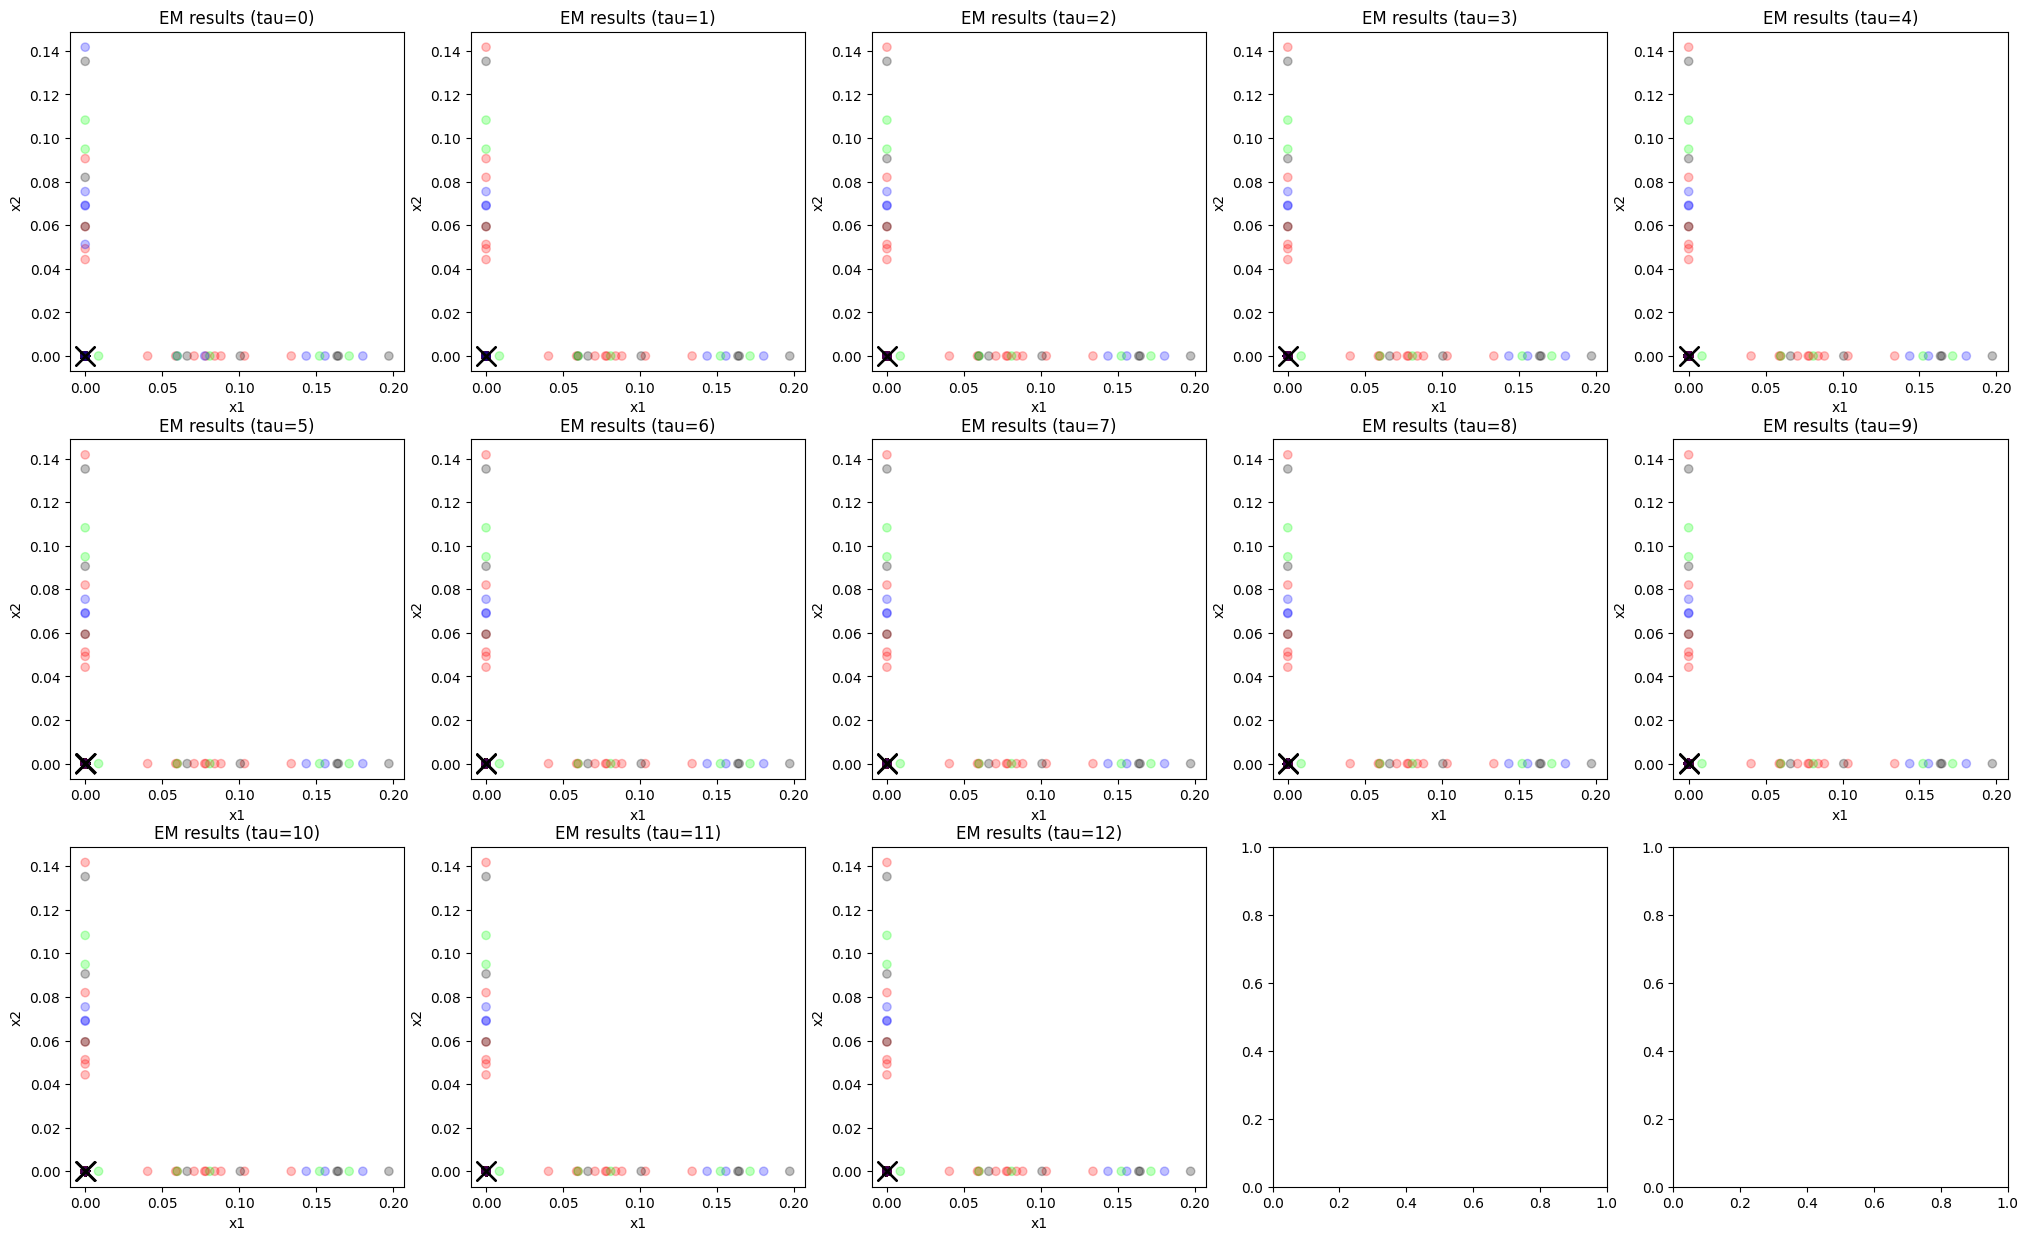

In [11]:
fig, axs = plot_docu(hard_em, features.toarray(), gran=1)

iteration 0
Mu_hat for iteration 0:
[[0.5488135  0.71518937 0.60276338 ... 0.34402606 0.26157885 0.39006907]
 [0.30089337 0.1597398  0.94173032 ... 0.74519745 0.19250094 0.35199941]
 [0.02130789 0.6214423  0.95035059 ... 0.01859348 0.95499249 0.70861025]
 [0.11836618 0.18068449 0.216401   ... 0.16759806 0.78601786 0.37977605]]
iteration 1
Mu_hat for iteration 1:
[[1.51707894e-04 5.60737626e-05 2.92281516e-04 ... 5.40316980e-04
  8.32734585e-05 1.96232553e-04]
 [1.64584382e-04 7.06546130e-05 3.59814096e-05 ... 9.14103294e-04
  5.23404481e-04 0.00000000e+00]
 [1.34171281e-04 8.83424744e-05 1.52059700e-04 ... 2.27910955e-04
  2.08279531e-04 2.84239334e-04]
 [1.38528251e-04 5.53360894e-05 1.03476933e-04 ... 3.68690474e-04
  2.08544257e-04 6.94459414e-05]]
iteration 2
Mu_hat for iteration 2:
[[1.69619073e-04 1.07623466e-04 2.92321656e-04 ... 5.40320673e-04
  1.14816176e-04 1.11983595e-04]
 [1.70805757e-04 7.33253939e-05 0.00000000e+00 ... 9.48656872e-04
  5.43189442e-04 0.00000000e+00]
 [1.

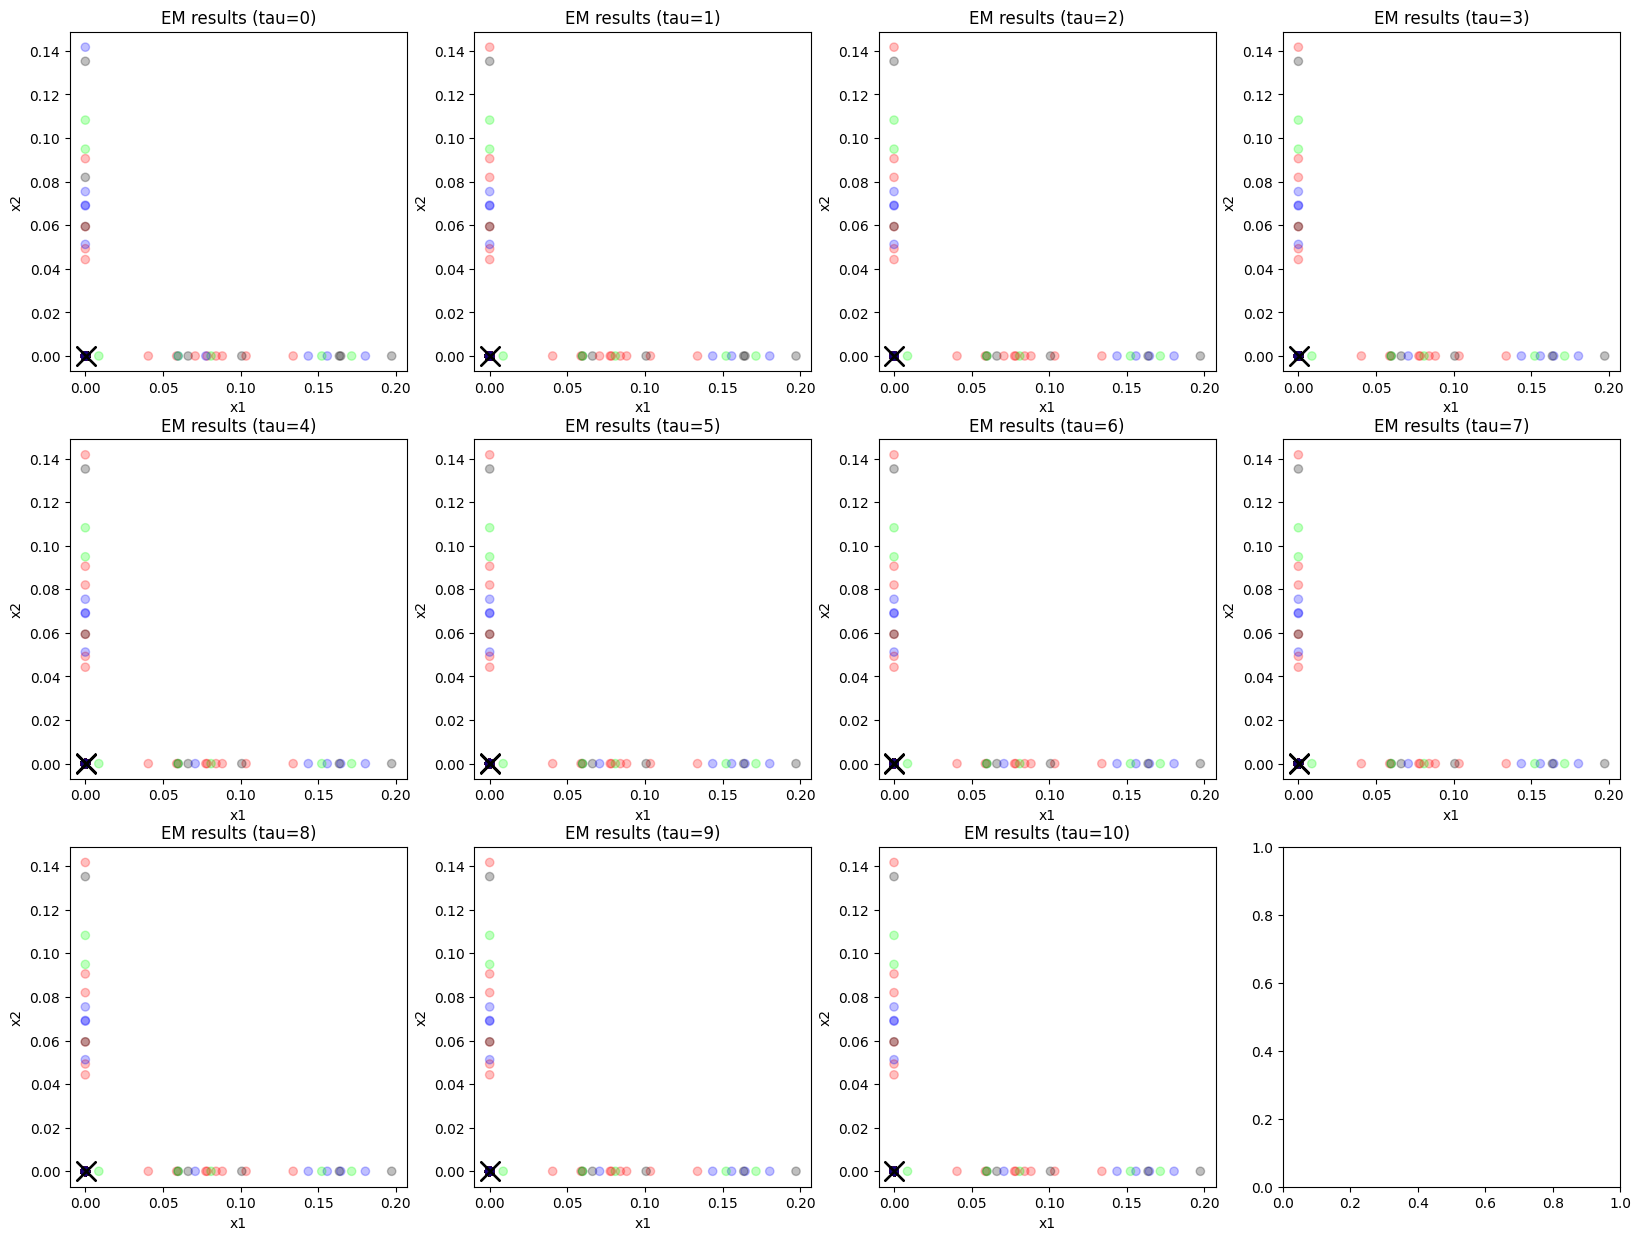

In [190]:
from sklearn.pipeline import make_pipeline

# soft clustering
K = 4
hard_em = SoftEM(K=K, tau_max=100, epsilon=0.01, random_state=0)
hard_em.fit(features.toarray(), verbose=True)
soft_cluster_assignments = hard_em.predict(features.toarray())

print(soft_cluster_assignments)
fig, axs = plot_docu(hard_em, features.toarray(), gran=1)

## V

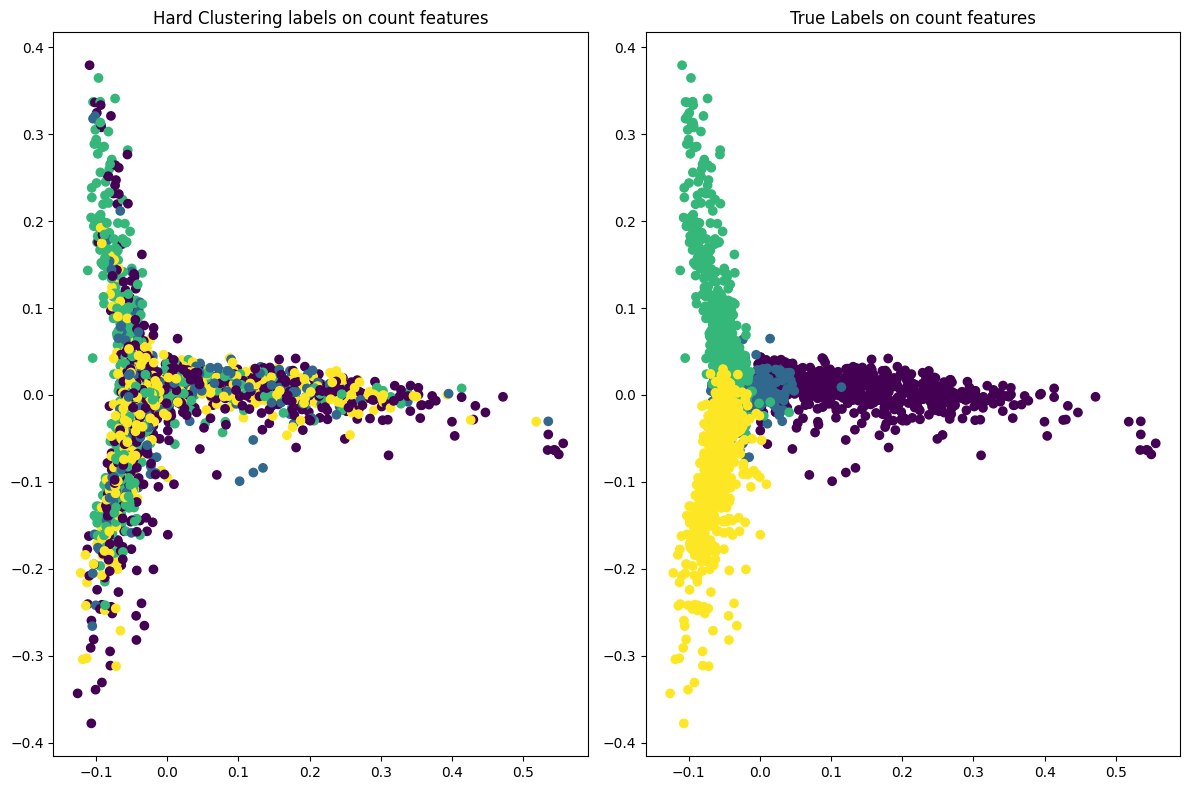

In [12]:
## perform pca on hard clustering
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

pca = PCA(n_components=2)
_2D_features = pca.fit_transform(features.toarray())
## plot the kmeans outcome
_, axs = plt.subplots(1, 2, figsize=(12, 8), tight_layout=True)
axs[0].scatter(x=_2D_features[:,0],y=_2D_features[:,1], c=cluster_assignments)
axs[0].set_title('Hard Clustering labels on count features')


## plot the original data
axs[1].scatter(x=_2D_features[:,0],y=_2D_features[:,1], c=docs.label.cat.codes)
axs[1].set_title('True Labels on count features')
plt.show()


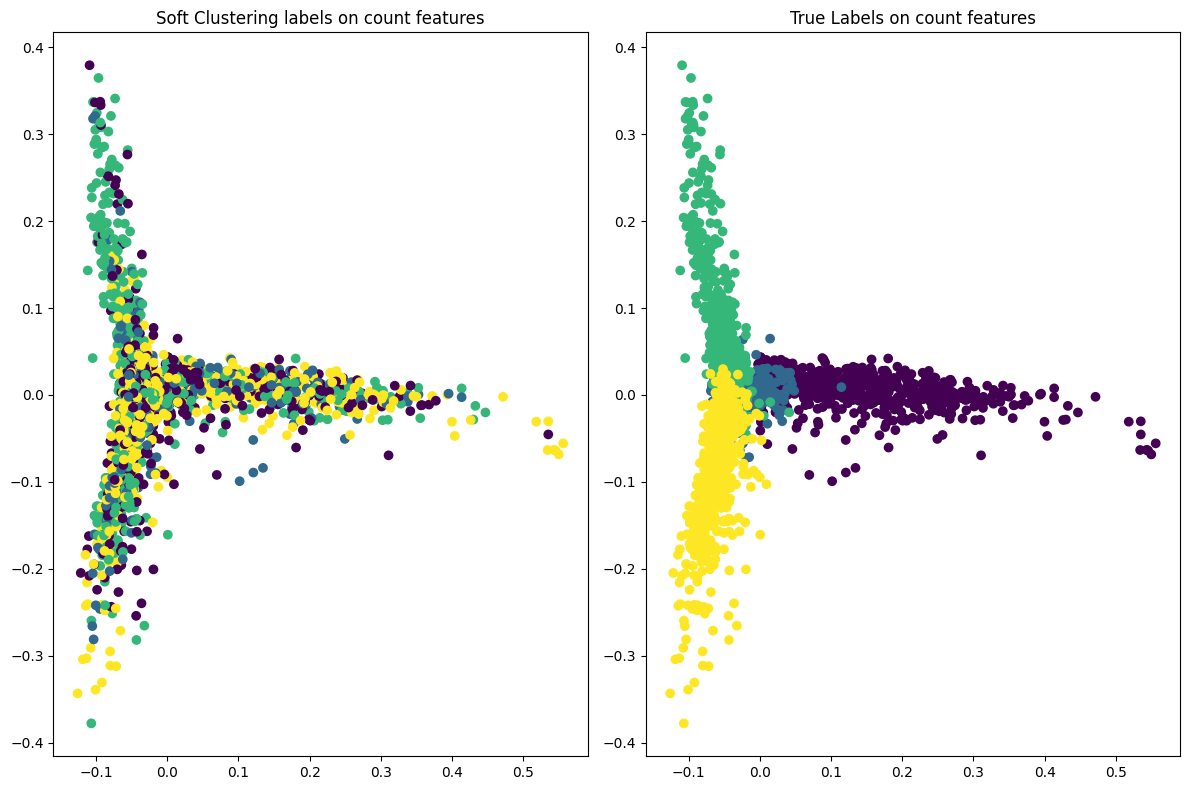

In [191]:
## perform pca on soft clustering
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

pca = PCA(n_components=2)
_2D_features = pca.fit_transform(features.toarray())
## plot the kmeans outcome
_, axs = plt.subplots(1, 2, figsize=(12, 8), tight_layout=True)
axs[0].scatter(x=_2D_features[:,0],y=_2D_features[:,1], c=soft_cluster_assignments)
axs[0].set_title('Soft Clustering labels on count features')


## plot the original data
axs[1].scatter(x=_2D_features[:,0],y=_2D_features[:,1], c=docs.label.cat.codes)
axs[1].set_title('True Labels on count features')
plt.show()


In hard clustering, the datapoint is only be groouped to 1 cluster so the result is either 0 or 1 and hence when visualising, the colour dot should only contains 1 colour. In soft clustering, the resulted vector is the probability of that datapoint belong to cluster k. Since it is a probability, it is a continuous value between 0 and 1. Hence when visualising in a plot, a datapoint might contrain more than 1 colour. Hard clustering is obtain by argmax while soft clustering is the local max.